# 3D fuel mapping for forest fire risk assessment

### Purpose

The objetive of this tutorial is to explain the Experiment 2 of the GeoSpatial use case in the H2020 CloudButton project. The main goal of the project is to create a Serverless Data Analytics Platform that aims to “democratize big data” by overly simplifying the overall life cycle and programming model thanks to serverless technologies. The idea is to tap into stateless functions to enable radically-simpler, more user-friendly data processing systems. The CloudButton platform will seamlessly integrate a Serverless Compute Engine, a Mutable Shared Data Middleware, and new Serverless Cloud Programming Abstractions on top.

The seconed experiment is based in a high-resolution forest fuel mapping. We will generate a fuel map of the Valencian Community in Spain, which include protected areas, using remote sensing fusion techniques and following an object-based classification model. Segmentation and supervised classification of Sentinel-2 images and 3D LiDAR-derived metrics of shrub
and tree canopy structure of two dates (reference years) will be used as input data in spatial
fire risk modelling, that also benefits of high resolution elevation models and other topographic input variables. The expected result is a high-resolution forest fire risk map that is useful for decision-making in forest planning and management (a ten-fold increase in map accuracy and better land-cover discrimination). Also, we will make a performance
comparison assessment of results obtained through CloudButton toolkit and conventional software and computer facilities

### 1. Setup


#### 1.1. Set up docker

To work with all the libraries in a **jupyter notebook** we will run a **docker** built for the experiment. It is necesarry to download <a href="https://www.docker.com/products/docker-desktop">docker desktop</a>, once it is done, we download and run the image of the docker that its gonna be used.

> docker pull mavsonnen/jupy-notebook:geosv2<br>
> docker run mavsonnen/jupy-notebook:geosv2

A **local directory** can be connected to a docker container creating a volume using <i>-v option</i>, change <i>local_path</i>:

> docker run -p 8888:8888 -v E:/cloudbutton:/home/jovyan/work mavsonnen/jupy-notebook:geosv2




#### 1.2. Importing libraries

The following libraries are necessary:

In [187]:
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale,StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans 
from shapely.geometry import mapping
from IPython.display import Image
from IPython.core.display import HTML 
from shapely.geometry import mapping
import rasterio as rio
from sklearn.pipeline import Pipeline
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import lithops
import shapely
import shutil
import pickle
import joblib
import gdal
import earthpy as ep
import earthpy.spatial as es
import time
import glob
import ogr
import os
import io
import pdal
#import rioxarray as rxr
import xarray as xr
import json
from matplotlib.colors import ListedColormap, BoundaryNorm
print("Libraries imported succesfully")

Libraries imported succesfully


#### 1.3. Configuration lithops

We have reached the serverless implementation thanks to the framework **lithops**.
All files that are going to run it will be on local.

![Image of Yaktocat](https://github.com/lithops-cloud/lithops/blob/master/docs/images/lithops_flat_cloud_1.png?raw=true)

Working with lithops require a configuration file like the one express below. More info can be found in the official **<a href="https://github.com/lithops-cloud/lithops">github</a> of Lithops**. 

 <i>
    config = { 'lithops' : {'storage_bucket' : 'BUCKET_NAME'},
    
           'ibm_cf':  {'endpoint': 'ENDPOINT',
                      'namespace': 'NAMESPACE',
                      'api_key': 'API_KEY'},
    
           'ibm_cos': {'region': 'REGION',
                      'api_key': 'API_KEY'}}

The **config** file with all the parameters is uploaded below

In [188]:
config_path = open("config.txt")
config_read = config_path.read()
config = json.loads(config_read)

#### 1.4. Downloading images

The LiDAR data has been obtained from the Spanish National Geographic Institute of the PNOA (National Plan of Aerial Orthophotography) <a href="http://centrodedescargas.cnig.es/CentroDescargas/catalogo.do?Serie=LIDAR">link</a>. 

1- Selecet LIDAR 2ª Cobertura (2015-Actualidad).

2- Select valencian community from top left.

3- Choose which data year we want to download. 

### 2. Dataset processing

#### 2.1 Remove noise data and create DEM (Digital Elevation Model)

The first step in Point cloud data is removing noise points. The filter used was the Radius Outlier Removal filter (ROR) due to its good results compared to other filters.


A Digital Elevation Model (DEM) or Digital Terrain Model (DTM) is a representation of the bare ground (bare earth) topographic surface of the Earth excluding trees, buildings, and any other surface objects. 

In this case we want to ignore any LiDAR classification values that may have already been calculated so that we can derive our own. In this example we apply a value of 0 (not classified) to the Classification dimension for every point.


The PDAL (Point Data Abstraction Library) is a very powerful tool for processing LiDAR point cloud data and very adept at extracting surface models based on point classification and filtering algorithms.

PDAL allows the composition of operations on point clouds into ‘pipelines’. These pipelines are written in the JSON format and define each step for the processing of the data in a sequence. This leads itself to highly customisable point cloud processing, that is repeatable and runs many steps in one execution of the program.



Define dem_extract function  that read lidar images (laz extension), then remove noise data, extract DEM and save the new image as tif extension.

In [3]:
def dem_extract(lasfile, outputfile):
        
       
        creating_json = {
                "pipeline": [
                    
                {
                        "type": "readers.las",
                        "filename": f"{lasfile}",
                        "spatialreference": "EPSG:25830"
                },
                    
                    
                {
                        "type":"filters.reprojection",
                        "in_srs":"EPSG:25830",
                        "out_srs":"EPSG:25830"
                },
                    
                    
                {
                      "type":"filters.assign",
                      "assignment":"Classification[:]=0"
                },
                    
                    
                 {
                          "type":"filters.elm"
                },
                
                {
                        "type":"filters.outlier",
                        "method":"radius",
                        "radius":1.0,
                        "min_k":4
                },
                {

                      "type":"filters.smrf",
                      "ignore":"Classification[7:7]",
                      "slope":0.2,
                      "window":16,
                      "threshold":0.45,
                      "scalar":1.2
                },

                {
                        "type": "filters.range",
                        "limits": "Classification[2:2]", # Classification equals 2 (corresponding to ground in LAS).
                     
                    

                },
                    

                {
                        "type": "writers.gdal",
                        "gdaldriver": "GTiff",
                        "nodata": "-9999",
                        "output_type": "max",
                        "resolution": 1, 
                        "filename": f"{outputfile}"
                }
                
                ]
        }
        consulta = json.dumps(creating_json, indent = 4)
        return consulta

In [4]:
lt=lithops.FunctionExecutor(mode='localhost')

# Create dem folder if not exist
carpeta_dem = "dem"
if not os.path.exists(carpeta_dem):
    os.makedirs(carpeta_dem)
# Read all lidar in the folder lidar_valenciana 
for file in os.listdir("data/lidar_valenciana"):
                if "laz" in file:
                        filez = file.split(".")[0]
                        outputfile = f"dem/dem_{filez}.tif"
                        lasfile =f"data/lidar_valenciana/{file}"

                        lt.call_async(dem_extract,[lasfile,outputfile])
                        results = lt.get_result()
                        pipeline = pdal.Pipeline(results)
                        pipeline.validate()  # Check if json options are good
                        pipeline.loglevel = 8
                        count = pipeline.execute()
                        lt.clean()
            

Lithops v2.2.3 init for Localhost
ExecutorID df28dc/0 | JobID A000 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A000 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A000 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A001 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A001 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A001 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A002 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A002 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A002 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A003 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A003 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A003 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A004 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A004 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A004 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A005 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A005 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A005 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A006 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A006 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A006 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A007 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A007 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A007 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A008 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A008 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A008 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A009 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A009 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A009 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A010 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A010 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A010 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A011 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A011 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A011 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A012 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A012 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A012 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A013 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A013 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A013 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A014 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A014 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A014 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A015 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A015 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A015 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A016 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A016 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A016 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A017 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A017 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A017 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A018 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A018 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A018 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A019 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A019 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A019 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A020 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A020 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A020 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A021 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A021 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A021 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A022 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A022 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A022 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A023 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A023 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A023 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A024 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A024 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A024 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A025 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A025 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A025 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A026 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A026 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A026 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A027 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A027 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A027 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A028 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A028 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A028 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A029 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A029 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A029 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A030 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A030 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A030 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A031 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A031 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A031 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A032 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A032 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A032 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A033 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A033 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A033 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A034 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A034 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A034 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A035 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A035 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A035 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A036 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A036 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A036 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A037 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A037 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A037 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A038 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A038 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A038 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A039 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A039 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A039 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A040 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A040 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A040 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A041 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A041 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A041 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A042 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A042 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A042 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A043 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A043 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A043 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A044 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A044 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A044 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A045 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A045 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A045 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A046 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A046 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A046 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A047 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A047 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A047 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A048 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A048 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A048 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A049 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A049 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A049 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A050 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A050 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A050 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A051 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A051 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A051 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A052 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A052 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A052 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A053 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A053 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A053 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A054 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A054 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A054 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A055 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A055 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A055 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A056 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A056 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A056 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A057 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A057 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A057 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A058 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A058 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A058 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A059 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A059 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A059 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A060 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A060 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A060 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A061 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A061 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A061 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A062 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A062 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A062 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A063 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A063 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A063 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A064 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A064 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A064 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A065 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A065 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A065 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A066 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A066 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A066 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A067 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A067 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A067 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A068 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A068 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A068 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A069 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A069 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A069 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A070 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A070 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A070 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A071 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A071 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A071 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A072 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A072 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A072 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A073 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A073 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A073 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A074 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A074 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A074 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A075 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A075 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A075 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A076 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A076 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A076 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A077 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A077 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A077 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A078 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A078 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A078 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A079 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A079 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A079 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A080 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A080 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A080 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A081 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A081 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A081 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A082 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A082 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A082 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A083 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A083 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A083 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A084 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A084 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A084 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A085 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A085 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A085 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A086 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A086 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A086 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A087 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A087 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A087 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A088 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A088 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A088 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A089 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A089 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A089 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A090 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A090 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A090 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A091 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A091 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A091 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A092 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A092 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A092 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A093 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A093 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A093 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A094 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A094 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A094 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A095 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A095 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A095 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A096 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A096 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A096 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A097 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A097 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A097 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A098 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A098 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A098 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A099 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A099 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A099 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A100 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A100 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A100 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A101 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A101 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A101 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A102 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A102 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A102 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A103 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A103 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A103 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A104 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A104 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A104 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A105 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A105 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A105 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A106 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A106 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A106 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A107 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A107 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A107 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A108 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A108 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A108 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A109 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A109 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A109 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A110 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A110 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A110 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A111 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A111 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A111 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A112 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A112 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A112 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A113 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A113 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A113 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A114 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A114 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A114 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A115 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A115 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A115 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A116 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A116 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A116 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A117 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A117 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A117 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A118 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A118 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A118 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A119 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A119 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A119 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A120 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A120 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A120 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A121 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A121 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A121 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A122 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A122 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A122 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A123 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A123 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A123 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A124 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A124 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A124 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A125 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A125 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A125 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A126 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A126 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A126 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A127 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A127 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A127 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A128 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A128 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A128 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A129 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A129 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A129 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A130 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A130 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A130 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A131 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A131 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A131 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A132 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A132 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A132 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A133 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A133 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A133 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A134 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A134 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A134 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A135 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A135 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A135 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A136 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A136 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A136 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A137 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A137 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A137 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A138 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A138 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A138 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A139 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A139 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A139 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A140 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A140 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A140 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A141 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A141 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A141 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A142 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A142 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A142 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A143 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A143 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A143 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A144 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A144 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A144 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A145 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A145 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A145 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A146 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A146 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A146 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A147 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A147 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A147 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A148 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A148 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A148 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A149 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A149 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A149 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A150 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A150 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A150 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A151 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A151 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A151 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A152 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A152 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A152 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A153 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A153 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A153 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A154 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A154 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A154 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A155 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A155 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A155 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A156 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A156 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A156 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A157 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A157 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A157 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A158 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A158 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A158 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A159 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A159 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A159 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A160 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A160 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A160 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A161 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A161 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A161 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A162 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A162 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A162 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A163 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A163 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A163 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A164 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A164 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A164 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A165 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A165 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A165 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A166 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A166 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A166 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A167 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A167 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A167 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A168 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A168 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A168 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A169 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A169 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A169 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A170 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A170 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A170 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A171 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A171 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A171 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A172 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A172 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A172 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A173 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A173 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A173 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A174 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A174 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A174 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A175 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A175 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A175 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A176 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A176 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A176 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A177 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A177 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A177 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A178 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A178 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A178 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A179 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A179 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A179 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A180 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A180 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A180 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A181 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A181 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A181 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A182 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A182 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A182 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A183 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A183 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A183 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A184 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A184 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A184 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A185 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A185 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A185 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A186 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A186 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A186 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A187 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A187 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A187 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A188 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A188 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A188 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A189 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A189 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A189 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A190 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A190 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A190 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A191 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A191 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A191 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A192 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A192 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A192 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A193 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A193 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A193 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A194 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A194 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A194 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A195 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A195 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A195 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A196 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A196 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A196 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A197 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A197 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A197 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A198 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A198 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A198 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 | JobID A199 - Selected Runtime: python3 
ExecutorID df28dc/0 | JobID A199 - Uploading function and data - Total: 1.5KiB
ExecutorID df28dc/0 | JobID A199 - dem_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/0 - Getting results...



ExecutorID df28dc/0 - Cleaning temporary data
ExecutorID df28dc/0 - Cleaning temporary data


#### 2.2  Remove noise data and Create DSM (Digital Surface Model)


Digital Surface Model (DSM) represents the top of the earth’s surface. It includes TREES, BUILDINGS and other objects that sit on the earth.

To Extract DSM we will write dsm_extract function that has pipeline composed for extracting the DSM from the cleaned LiDAR point cloud.

In this case we want to ignore any LiDAR classification values that may have already been calculated so that we can derive our own. In this example we apply a value of 0 (not classified) to the Classification dimension for every point.



Any time we have points classified as ground, we may wish to extract just these points, e.g., to create a digital terrain model (DTM). In this case, we use a range filter as shown.



In [5]:
def dsm_extract(lasfile, outputfile):
        
        creating_json = {
                "pipeline": [
                {
                        "type": "readers.las",
                        "filename": f"{lasfile}",
                        "spatialreference": "EPSG:25830"
                },
                {

                        "type":"filters.reprojection",

                        "in_srs":"EPSG:25830",

                        "out_srs":"EPSG:25830"

                },
                {
                        "type":"filters.outlier",
                        "method":"radius",
                        "radius":1.0,
                        "min_k":4
                },
                {
                        "type":"filters.range",
                        "limits":"Classification![7:7]"  # Classification equals 2 (corresponding to noise points in LAS).
                },
                {
                        "type":"filters.range",
                        "limits":"returnnumber[1:1]"

                },


                {
                        "type": "writers.gdal",
                        "gdaldriver": "GTiff",
                        "nodata": "-9999",
                        "output_type": "max",
                        "resolution": 1, 
                        "filename": f"{outputfile}"
                }
                
                ]
        }
        consulta = json.dumps(creating_json, indent = 4)
        return consulta

In [6]:
lt=lithops.FunctionExecutor(mode='localhost')

# Create dem folder if not exist
carpeta_dsm = "dsm"
if not os.path.exists(carpeta_dsm):
    os.makedirs(carpeta_dsm)
# Read all lidar in the folder lidar_valenciana 
for file in os.listdir("data/lidar_valenciana"):
                if "laz" in file:
                        filez = file.split(".")[0]
                        outputfile = f"dsm/dsm_{filez}.tif"
                        lasfile =f"data/lidar_valenciana/{file}"

                        lt.call_async(dsm_extract,[lasfile,outputfile])
                        results = lt.get_result()
                        pipeline = pdal.Pipeline(results)
                        pipeline.validate()  # Check if json options are good
                        pipeline.loglevel = 8
                        count = pipeline.execute()
                        lt.clean()
             

Lithops v2.2.3 init for Localhost
ExecutorID df28dc/1 | JobID A000 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A000 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A000 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A001 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A001 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A001 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A002 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A002 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A002 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A003 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A003 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A003 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A004 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A004 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A004 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A005 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A005 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A005 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A006 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A006 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A006 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A007 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A007 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A007 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A008 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A008 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A008 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A009 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A009 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A009 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A010 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A010 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A010 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A011 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A011 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A011 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A012 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A012 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A012 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A013 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A013 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A013 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A014 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A014 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A014 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A015 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A015 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A015 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A016 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A016 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A016 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A017 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A017 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A017 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A018 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A018 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A018 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A019 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A019 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A019 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A020 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A020 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A020 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A021 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A021 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A021 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A022 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A022 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A022 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A023 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A023 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A023 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A024 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A024 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A024 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A025 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A025 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A025 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A026 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A026 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A026 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A027 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A027 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A027 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A028 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A028 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A028 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A029 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A029 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A029 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A030 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A030 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A030 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A031 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A031 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A031 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A032 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A032 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A032 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A033 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A033 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A033 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A034 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A034 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A034 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A035 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A035 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A035 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A036 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A036 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A036 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A037 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A037 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A037 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A038 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A038 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A038 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A039 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A039 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A039 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A040 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A040 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A040 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A041 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A041 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A041 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A042 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A042 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A042 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A043 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A043 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A043 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A044 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A044 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A044 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A045 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A045 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A045 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A046 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A046 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A046 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A047 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A047 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A047 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A048 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A048 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A048 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A049 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A049 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A049 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A050 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A050 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A050 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A051 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A051 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A051 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A052 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A052 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A052 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A053 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A053 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A053 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A054 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A054 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A054 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A055 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A055 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A055 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A056 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A056 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A056 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A057 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A057 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A057 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A058 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A058 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A058 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A059 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A059 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A059 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A060 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A060 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A060 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A061 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A061 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A061 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A062 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A062 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A062 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A063 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A063 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A063 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A064 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A064 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A064 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A065 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A065 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A065 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A066 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A066 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A066 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A067 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A067 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A067 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A068 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A068 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A068 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A069 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A069 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A069 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A070 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A070 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A070 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A071 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A071 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A071 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A072 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A072 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A072 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A073 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A073 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A073 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A074 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A074 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A074 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A075 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A075 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A075 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A076 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A076 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A076 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A077 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A077 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A077 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A078 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A078 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A078 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A079 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A079 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A079 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A080 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A080 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A080 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A081 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A081 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A081 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A082 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A082 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A082 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A083 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A083 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A083 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A084 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A084 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A084 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A085 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A085 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A085 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A086 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A086 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A086 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A087 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A087 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A087 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A088 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A088 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A088 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A089 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A089 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A089 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A090 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A090 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A090 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A091 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A091 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A091 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A092 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A092 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A092 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A093 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A093 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A093 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A094 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A094 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A094 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A095 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A095 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A095 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A096 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A096 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A096 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A097 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A097 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A097 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A098 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A098 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A098 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A099 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A099 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A099 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A100 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A100 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A100 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A101 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A101 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A101 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A102 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A102 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A102 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A103 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A103 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A103 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A104 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A104 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A104 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A105 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A105 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A105 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A106 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A106 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A106 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A107 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A107 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A107 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A108 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A108 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A108 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A109 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A109 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A109 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A110 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A110 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A110 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A111 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A111 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A111 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A112 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A112 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A112 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A113 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A113 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A113 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A114 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A114 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A114 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A115 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A115 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A115 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A116 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A116 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A116 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A117 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A117 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A117 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A118 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A118 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A118 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A119 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A119 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A119 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A120 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A120 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A120 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A121 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A121 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A121 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A122 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A122 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A122 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A123 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A123 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A123 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A124 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A124 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A124 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A125 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A125 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A125 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A126 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A126 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A126 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A127 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A127 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A127 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A128 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A128 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A128 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A129 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A129 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A129 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A130 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A130 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A130 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A131 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A131 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A131 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A132 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A132 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A132 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A133 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A133 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A133 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A134 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A134 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A134 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A135 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A135 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A135 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A136 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A136 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A136 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A137 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A137 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A137 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A138 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A138 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A138 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A139 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A139 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A139 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A140 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A140 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A140 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A141 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A141 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A141 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A142 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A142 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A142 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A143 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A143 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A143 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A144 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A144 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A144 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A145 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A145 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A145 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A146 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A146 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A146 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A147 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A147 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A147 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A148 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A148 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A148 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A149 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A149 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A149 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A150 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A150 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A150 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A151 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A151 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A151 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A152 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A152 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A152 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A153 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A153 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A153 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A154 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A154 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A154 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A155 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A155 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A155 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A156 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A156 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A156 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A157 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A157 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A157 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A158 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A158 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A158 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A159 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A159 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A159 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A160 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A160 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A160 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A161 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A161 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A161 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A162 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A162 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A162 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A163 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A163 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A163 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A164 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A164 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A164 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A165 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A165 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A165 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A166 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A166 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A166 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A167 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A167 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A167 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A168 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A168 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A168 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A169 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A169 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A169 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A170 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A170 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A170 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A171 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A171 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A171 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A172 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A172 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A172 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A173 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A173 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A173 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A174 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A174 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A174 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A175 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A175 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A175 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A176 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A176 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A176 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A177 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A177 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A177 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A178 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A178 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A178 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A179 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A179 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A179 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A180 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A180 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A180 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A181 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A181 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A181 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A182 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A182 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A182 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A183 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A183 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A183 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A184 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A184 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A184 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A185 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A185 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A185 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A186 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A186 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A186 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A187 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A187 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A187 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A188 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A188 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A188 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A189 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A189 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A189 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A190 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A190 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A190 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A191 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A191 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A191 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A192 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A192 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A192 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A193 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A193 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A193 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A194 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A194 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A194 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A195 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A195 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A195 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A196 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A196 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A196 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A197 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A197 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A197 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 | JobID A198 - Selected Runtime: python3 
ExecutorID df28dc/1 | JobID A198 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/1 | JobID A198 - dsm_extract() Invocation done - Total: 1 activations
ExecutorID df28dc/1 - Getting results...



ExecutorID df28dc/1 - Cleaning temporary data
ExecutorID df28dc/1 - Cleaning temporary data



#### 2.3  Create CHM (Canopy Height Model)

The height or residual distance between the ground and the top of the of objects above the ground. This includes the actual heights of trees, builds and any other objects on the earth’s surface. This CHM is created by subtracting the DTM from the DSM.


Once the DSM and DTM models have are computed, GDAL can be used to run a raster calculator to output the CHM.



In [7]:
# Create CHM folder if not exist
carpeta_chm = "chm"
if not os.path.exists(carpeta_chm):
    os.makedirs(carpeta_chm)
for file in os.listdir("data/lidar_valenciana"):
                if "laz" in file:
                        # Define input and output files

                        filez = file.split(".")[0]
                        inputfiles_a = f"dem/dem_{filez}.tif"
                        inputfiles_b = f"dsm/dsm_{filez}.tif"
                        outputfile = f"chm/chm_{filez}.tif"
                        # Generate the command
                        command = 'gdal_calc.py -A {0} -B {1}   --calc="B-A" --outfile {2}'.format(inputfiles_a,inputfiles_b, outputfile)
                        # Run the command. os.system() returns value zero if the command was executed succesfully
                        os.system(command)
                       

Another way to create CHM

In [8]:
# Create CHM folder if not exist
'''
carpeta_chm = "chm_test"

if not os.path.exists(carpeta_chm):
    os.makedirs(carpeta_chm)
for file in os.listdir("lidar_valenciana"):
                if "laz" in file:
                        # Define input and output files

                        filez = file.split(".")[0]
                        inputfiles_a = f"dem/dem_{filez}.tif"
                        inputfiles_b = f"dsm/dsm_{filez}.tif"
                        outputfile = f"chm/chm_{filez}.tif"
                        # Generate the command
                        lidar_dem_xr=rxr.open_rasterio(inputfiles_a, masked=True).squeeze()
                        lidar_dsm_xr=rxr.open_rasterio(inputfiles_b, masked=True).squeeze()
                        lidar_chm_xr = lidar_dsm_xr - lidar_dem_xr
                        lidar_chm_xr.rio.to_raster(outputfile)

               '''     


'\ncarpeta_chm = "chm_test"\n\nif not os.path.exists(carpeta_chm):\n    os.makedirs(carpeta_chm)\nfor file in os.listdir("santiago"):\n                if "laz" in file:\n                        # Define input and output files\n\n                        filez = file.split(".")[0]\n                        inputfiles_a = f"dem/dem_{filez}.tif"\n                        inputfiles_b = f"dsm/dsm_{filez}.tif"\n                        outputfile = f"chm/chm_{filez}.tif"\n                        # Generate the command\n                        lidar_dem_xr=rxr.open_rasterio(inputfiles_a, masked=True).squeeze()\n                        lidar_dsm_xr=rxr.open_rasterio(inputfiles_b, masked=True).squeeze()\n                        lidar_chm_xr = lidar_dsm_xr - lidar_dem_xr\n                        lidar_chm_xr.rio.to_raster(outputfile)\n\n               '

In [ ]:
infile = 'chm/chm_PNOA_2017_CLM-CAS_244-4452_ORT-CLA-IRC.tif'
chm_foto = rxr.open_rasterio(infile, masked=True).squeeze()


class_bins = [-np.inf, 2, 5, 10, np.inf]

chm_class = xr.apply_ufunc(np.digitize,
                                 chm_foto,
                                 class_bins)
# Values of 5 represent missing data
im = chm_class.plot.imshow()


In [ ]:
# Mask out values not equalt to 5
chm_class = chm_class.where(chm_class != 5.)
chm_class
# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10,5))
chm_class.plot.imshow( cmap="terrain")
ax.set(title="Classified Plot With a Colorbar")

ax.set_axis_off()
plt.show()


## Topography characteristics

Topography Landscape topography has an impact on the environmental conditions, the amount of certain types  of  vegetation,  and  therefore,  has  a  direct  influence  upon  fire  propagation.  In  the following,  we  focus  on  the  aspect,  slope  and  elevation  that  are  input  variables  of  fire  spread models and that can be retrieved using LiDAR.  

a) Aspect: the aspect is the direction a slope is facing. The solar orientation generally determines the amount of heat provided by the Sun and therefore has high influence on  the  amount,  condition  and  type  of  fuels.  South-southwest  slopes  are  more  exposed  to sunlight  and  often  correspond  to  lighter  and  sparser  fuels,  higher  temperatures,  lower humidity  and  lower  fuel  moisture.  They  consequently  are  most  critical  in  terms  of  start  and spread of wildland fires. On the contrary, north-facing slopes are less subjected to fire activity than  south-facing  slopes.  They  are  more  shaded,  which  leads  to  heavier  fuels,  lower temperature, higher humidity and higher fuel moisture. North-facing vs south-facing slopes.  
 

In [8]:
def compute_slope (input_dem ,output_slope_map ):
        # Generate the command
        command = 'gdaldem  slope {0}  {1} -compute_edges'.format(input_dem,output_slope_map)
        # Run the command. os.system() returns value zero if the command was executed succesfully
        return (os.system(command))

In [9]:
lt=lithops.FunctionExecutor(mode='localhost')

# Create slop folder if not exist
carpeta_slop = "slop"
if not os.path.exists(carpeta_slop):
    os.makedirs(carpeta_slop)
for file in os.listdir("data/lidar_valenciana"):
                if "laz" in file:
                        # Define input and output files

                        filez = file.split(".")[0]
                        input_dem = f"dem/dem_{filez}.tif"
                        output_slope_map = f"slop/slop_{filez}.tif"

                        lt.call_async(compute_slope,[input_dem,output_slope_map])
                        results = lt.get_result()
                  


Lithops v2.2.3 init for Localhost
ExecutorID df28dc/2 | JobID A000 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A000 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A000 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A001 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A001 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A001 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A002 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A002 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A002 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A003 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A003 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A003 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A004 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A004 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A004 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A005 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A005 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A005 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A006 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A006 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A006 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A007 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A007 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A007 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A008 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A008 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A008 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A009 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A009 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A009 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A010 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A010 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A010 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A011 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A011 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A011 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A012 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A012 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A012 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A013 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A013 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A013 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A014 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A014 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A014 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A015 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A015 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A015 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A016 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A016 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A016 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A017 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A017 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A017 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A018 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A018 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A018 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A019 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A019 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A019 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A020 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A020 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A020 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A021 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A021 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A021 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A022 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A022 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A022 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A023 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A023 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A023 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A024 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A024 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A024 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A025 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A025 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A025 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A026 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A026 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A026 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A027 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A027 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A027 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A028 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A028 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A028 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A029 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A029 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A029 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A030 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A030 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A030 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A031 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A031 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A031 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A032 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A032 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A032 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A033 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A033 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A033 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A034 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A034 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A034 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A035 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A035 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A035 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A036 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A036 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A036 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A037 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A037 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A037 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A038 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A038 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A038 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A039 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A039 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A039 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A040 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A040 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A040 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A041 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A041 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A041 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A042 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A042 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A042 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A043 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A043 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A043 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A044 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A044 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A044 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A045 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A045 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A045 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A046 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A046 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A046 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A047 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A047 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A047 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A048 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A048 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A048 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A049 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A049 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A049 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A050 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A050 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A050 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A051 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A051 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A051 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A052 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A052 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A052 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A053 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A053 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A053 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A054 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A054 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A054 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A055 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A055 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A055 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A056 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A056 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A056 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A057 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A057 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A057 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A058 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A058 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A058 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A059 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A059 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A059 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A060 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A060 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A060 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A061 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A061 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A061 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A062 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A062 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A062 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A063 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A063 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A063 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A064 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A064 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A064 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A065 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A065 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A065 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A066 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A066 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A066 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A067 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A067 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A067 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A068 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A068 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A068 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A069 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A069 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A069 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A070 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A070 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A070 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A071 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A071 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A071 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A072 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A072 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A072 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A073 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A073 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A073 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A074 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A074 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A074 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A075 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A075 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A075 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A076 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A076 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A076 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A077 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A077 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A077 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A078 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A078 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A078 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A079 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A079 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A079 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A080 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A080 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A080 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A081 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A081 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A081 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A082 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A082 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A082 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A083 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A083 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A083 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A084 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A084 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A084 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A085 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A085 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A085 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A086 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A086 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A086 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A087 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A087 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A087 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A088 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A088 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A088 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A089 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A089 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A089 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A090 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A090 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A090 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A091 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A091 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A091 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A092 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A092 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A092 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A093 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A093 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A093 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A094 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A094 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A094 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A095 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A095 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A095 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A096 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A096 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A096 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A097 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A097 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A097 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A098 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A098 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A098 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A099 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A099 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A099 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A100 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A100 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A100 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A101 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A101 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A101 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A102 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A102 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A102 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A103 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A103 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A103 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A104 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A104 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A104 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A105 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A105 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A105 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A106 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A106 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A106 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A107 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A107 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A107 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A108 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A108 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A108 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A109 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A109 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A109 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A110 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A110 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A110 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A111 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A111 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A111 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A112 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A112 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A112 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A113 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A113 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A113 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A114 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A114 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A114 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A115 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A115 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A115 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A116 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A116 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A116 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A117 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A117 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A117 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A118 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A118 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A118 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A119 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A119 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A119 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A120 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A120 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A120 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A121 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A121 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A121 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A122 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A122 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A122 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A123 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A123 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A123 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A124 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A124 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A124 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A125 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A125 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A125 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A126 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A126 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A126 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A127 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A127 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A127 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A128 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A128 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A128 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A129 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A129 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A129 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A130 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A130 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A130 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A131 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A131 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A131 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A132 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A132 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A132 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A133 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A133 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A133 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A134 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A134 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A134 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A135 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A135 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A135 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A136 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A136 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A136 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A137 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A137 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A137 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A138 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A138 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A138 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A139 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A139 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A139 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A140 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A140 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A140 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A141 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A141 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A141 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A142 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A142 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A142 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A143 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A143 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A143 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A144 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A144 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A144 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A145 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A145 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A145 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A146 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A146 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A146 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A147 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A147 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A147 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A148 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A148 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A148 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A149 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A149 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A149 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A150 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A150 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A150 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A151 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A151 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A151 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A152 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A152 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A152 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A153 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A153 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A153 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A154 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A154 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A154 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A155 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A155 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A155 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A156 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A156 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A156 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A157 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A157 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A157 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A158 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A158 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A158 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A159 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A159 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A159 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A160 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A160 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A160 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A161 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A161 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A161 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A162 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A162 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A162 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A163 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A163 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A163 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A164 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A164 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A164 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A165 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A165 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A165 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A166 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A166 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A166 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A167 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A167 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A167 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A168 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A168 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A168 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A169 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A169 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A169 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A170 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A170 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A170 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A171 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A171 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A171 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A172 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A172 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A172 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A173 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A173 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A173 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A174 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A174 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A174 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A175 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A175 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A175 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A176 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A176 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A176 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A177 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A177 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A177 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A178 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A178 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A178 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A179 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A179 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A179 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A180 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A180 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A180 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A181 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A181 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A181 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A182 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A182 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A182 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A183 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A183 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A183 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A184 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A184 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A184 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A185 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A185 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A185 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A186 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A186 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A186 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A187 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A187 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A187 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A188 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A188 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A188 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A189 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A189 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A189 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A190 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A190 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A190 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A191 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A191 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A191 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A192 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A192 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A192 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A193 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A193 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A193 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A194 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A194 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A194 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A195 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A195 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A195 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A196 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A196 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A196 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A197 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A197 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A197 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A198 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A198 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A198 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data
ExecutorID df28dc/2 | JobID A199 - Selected Runtime: python3 
ExecutorID df28dc/2 | JobID A199 - Uploading function and data - Total: 839.0B
ExecutorID df28dc/2 | JobID A199 - compute_slope() Invocation done - Total: 1 activations
ExecutorID df28dc/2 - Getting results...



ExecutorID df28dc/2 - Cleaning temporary data


b) Slope: it is the degree of incline of a hill side. The steeper  the slope, the faster  the  fire  spreads,  and  it  burns  more  rapidly uphill  than  downhill.  An explanation  for  these  two  phenomena  is  that  the  fuel  above  the  fire  is  brought  into  closer contact with the upward moving flames. Another concern about steep slopes is the possibility that burning materials roll down the hill and ignite the fuel below the main fire. A  surface  fire  is  primarily  influenced  by  the  amount  of  fuel  and  the  wind  speed,  but  a  fire starting near the bottom of a slope in normal daytime upslope wind conditions should spread faster and over a larger area than a fire starting near the top of the slope. 

In [10]:
def compute_aspect (input_dem ,output_aspect_map ):
        # Generate the command
        command = 'gdaldem  aspect {0}  {1} -compute_edges'.format(input_dem,output_aspect_map)
        # Run the command. os.system() returns value zero if the command was executed succesfully
        return (os.system(command))

In [11]:
lt=lithops.FunctionExecutor(mode='localhost')
# Create aspect folder if not exist
carpeta_aspect = "aspect"

if not os.path.exists(carpeta_aspect):
    os.makedirs(carpeta_aspect)
for file in os.listdir("data/lidar_valenciana"):
                if "laz" in file:
                        # Define input and output files

                        filez = file.split(".")[0]
                        input_dem = f"dem/dem_{filez}.tif"
                        output_aspect_map = f"aspect/aspect_{filez}.tif"

                        lt.call_async(compute_aspect,[input_dem,output_aspect_map])
                        results = lt.get_result()
                     

Lithops v2.2.3 init for Localhost
ExecutorID df28dc/3 | JobID A000 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A000 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A000 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A001 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A001 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A001 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A002 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A002 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A002 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A003 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A003 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A003 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A004 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A004 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A004 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A005 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A005 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A005 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A006 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A006 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A006 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A007 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A007 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A007 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A008 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A008 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A008 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A009 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A009 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A009 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A010 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A010 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A010 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A011 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A011 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A011 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A012 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A012 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A012 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A013 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A013 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A013 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A014 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A014 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A014 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A015 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A015 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A015 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A016 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A016 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A016 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A017 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A017 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A017 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A018 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A018 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A018 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A019 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A019 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A019 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A020 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A020 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A020 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A021 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A021 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A021 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A022 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A022 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A022 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A023 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A023 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A023 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A024 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A024 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A024 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A025 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A025 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A025 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A026 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A026 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A026 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A027 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A027 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A027 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A028 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A028 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A028 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A029 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A029 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A029 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A030 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A030 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A030 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A031 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A031 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A031 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A032 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A032 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A032 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A033 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A033 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A033 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A034 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A034 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A034 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A035 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A035 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A035 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A036 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A036 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A036 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A037 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A037 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A037 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A038 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A038 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A038 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A039 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A039 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A039 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A040 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A040 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A040 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A041 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A041 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A041 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A042 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A042 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A042 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A043 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A043 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A043 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A044 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A044 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A044 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A045 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A045 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A045 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A046 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A046 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A046 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A047 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A047 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A047 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A048 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A048 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A048 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A049 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A049 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A049 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A050 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A050 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A050 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A051 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A051 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A051 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A052 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A052 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A052 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A053 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A053 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A053 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A054 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A054 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A054 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A055 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A055 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A055 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A056 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A056 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A056 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A057 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A057 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A057 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A058 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A058 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A058 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A059 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A059 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A059 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A060 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A060 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A060 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A061 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A061 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A061 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A062 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A062 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A062 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A063 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A063 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A063 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A064 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A064 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A064 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A065 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A065 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A065 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A066 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A066 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A066 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A067 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A067 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A067 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A068 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A068 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A068 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A069 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A069 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A069 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A070 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A070 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A070 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A071 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A071 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A071 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A072 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A072 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A072 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A073 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A073 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A073 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A074 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A074 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A074 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A075 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A075 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A075 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A076 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A076 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A076 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A077 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A077 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A077 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A078 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A078 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A078 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A079 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A079 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A079 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A080 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A080 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A080 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A081 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A081 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A081 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A082 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A082 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A082 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A083 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A083 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A083 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A084 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A084 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A084 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A085 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A085 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A085 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A086 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A086 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A086 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A087 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A087 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A087 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A088 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A088 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A088 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A089 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A089 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A089 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A090 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A090 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A090 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A091 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A091 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A091 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A092 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A092 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A092 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A093 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A093 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A093 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A094 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A094 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A094 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A095 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A095 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A095 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A096 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A096 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A096 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A097 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A097 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A097 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A098 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A098 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A098 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A099 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A099 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A099 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A100 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A100 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A100 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A101 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A101 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A101 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A102 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A102 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A102 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A103 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A103 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A103 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A104 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A104 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A104 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A105 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A105 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A105 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A106 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A106 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A106 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A107 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A107 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A107 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A108 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A108 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A108 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A109 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A109 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A109 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A110 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A110 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A110 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A111 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A111 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A111 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A112 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A112 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A112 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A113 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A113 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A113 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A114 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A114 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A114 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A115 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A115 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A115 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A116 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A116 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A116 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A117 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A117 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A117 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A118 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A118 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A118 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A119 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A119 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A119 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A120 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A120 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A120 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A121 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A121 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A121 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A122 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A122 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A122 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A123 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A123 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A123 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A124 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A124 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A124 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A125 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A125 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A125 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A126 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A126 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A126 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A127 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A127 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A127 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A128 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A128 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A128 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A129 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A129 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A129 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A130 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A130 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A130 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A131 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A131 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A131 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A132 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A132 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A132 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A133 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A133 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A133 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A134 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A134 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A134 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A135 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A135 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A135 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A136 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A136 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A136 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A137 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A137 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A137 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A138 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A138 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A138 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A139 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A139 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A139 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A140 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A140 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A140 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A141 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A141 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A141 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A142 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A142 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A142 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A143 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A143 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A143 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A144 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A144 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A144 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A145 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A145 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A145 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A146 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A146 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A146 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A147 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A147 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A147 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A148 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A148 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A148 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A149 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A149 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A149 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A150 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A150 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A150 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A151 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A151 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A151 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A152 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A152 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A152 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A153 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A153 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A153 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A154 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A154 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A154 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A155 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A155 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A155 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A156 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A156 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A156 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A157 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A157 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A157 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A158 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A158 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A158 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A159 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A159 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A159 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A160 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A160 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A160 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A161 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A161 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A161 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A162 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A162 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A162 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A163 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A163 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A163 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A164 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A164 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A164 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A165 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A165 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A165 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A166 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A166 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A166 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A167 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A167 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A167 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A168 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A168 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A168 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A169 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A169 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A169 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A170 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A170 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A170 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A171 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A171 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A171 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A172 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A172 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A172 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A173 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A173 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A173 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A174 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A174 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A174 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A175 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A175 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A175 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A176 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A176 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A176 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A177 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A177 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A177 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A178 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A178 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A178 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A179 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A179 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A179 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A180 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A180 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A180 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A181 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A181 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A181 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A182 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A182 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A182 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A183 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A183 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A183 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A184 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A184 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A184 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A185 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A185 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A185 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A186 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A186 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A186 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A187 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A187 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A187 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A188 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A188 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A188 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A189 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A189 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A189 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A190 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A190 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A190 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A191 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A191 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A191 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A192 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A192 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A192 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A193 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A193 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A193 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A194 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A194 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A194 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A195 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A195 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A195 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A196 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A196 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A196 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A197 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A197 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A197 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A198 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A198 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A198 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data
ExecutorID df28dc/3 | JobID A199 - Selected Runtime: python3 
ExecutorID df28dc/3 | JobID A199 - Uploading function and data - Total: 848.0B
ExecutorID df28dc/3 | JobID A199 - compute_aspect() Invocation done - Total: 1 activations
ExecutorID df28dc/3 - Getting results...



ExecutorID df28dc/3 - Cleaning temporary data


###  Machine Learning - KMeans


We use clustering to group pixels together based on their similarities because we have no information about which ones belong together.

Prepare the names of data that we would train it.

In [102]:
data= []
i=0
for file in os.listdir("data/lidar_valenciana"):
                if "laz" in file:
                        # Define input and output files

                        filez = file.split(".")[0]
                        input_dem = f"dem/dem_{filez}.tif"
                        input_slop = f"slop/slop_{filez}.tif"
                        input_aspect = f"aspect/aspect_{filez}.tif"
                        raster_fns = [input_dem,input_slop,input_aspect]   
                        data.append(raster_fns)
                        i =i+1
                        if i ==200:
                            break


In [56]:
# Define number of images we want to use it as training data.
num_of_img = 20
# Define X_train array to save training data in it. 
X_train = np.array([], dtype=np.int8).reshape(0,3) # pixels

# For loop read 20 images, after that saves the pixels in X_train
for i in range(num_of_img):

    band_list = []
    for image in data[i]:
        with rio.open(image, 'r') as src:
            band = src.read(1)
            band = np.nan_to_num(band)
            band_list.append(band)
    bands_stack = np.dstack(band_list)
    width, height, depth = bands_stack.shape
    model_input = bands_stack.reshape(width * height, depth)
    X_train = np.vstack((X_train,model_input))
    


We have approximately 73 million training patterns.

In [58]:
# Train data size
X_train.shape

(72936816, 3)

In [60]:
no_of_ranges =  np.arange(3, 11, 1)
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}
models = []
predicted = []
inertia_vals = []
s_scores = []
for n_clust in no_of_ranges:
    kmeans = KMeans(n_clusters=n_clust,**kmeans_kwargs)
    y_pred =kmeans.fit_predict(X_train)

    # Append model
    models.append(kmeans)

    # Calculate metrics
    s_scores.append(silhouette_score(X_train, y_pred, sample_size=1000))
    #inertia_vals.append(pipe.inertia_)
    inertia_vals.append(kmeans.inertia_)

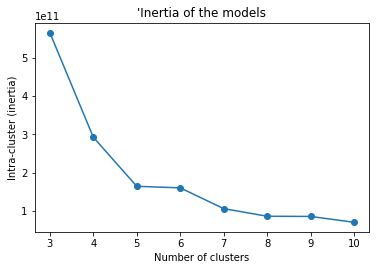

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(no_of_ranges, inertia_vals, marker='o')
ax.set_title("'Inertia of the models")
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Intra-cluster (inertia)');


Text(0.5, 0, 'Number of clusters')

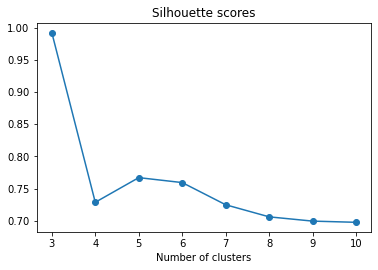

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(no_of_ranges, s_scores, marker='o')
ax.set_title("Silhouette scores")
ax.set_xlabel('Number of clusters')


The number of clusters (k) is the most important hyperparameter in K-Means clustering. So to find the optimal value of k we apply Elbow method and Silhouette method.

Elbow method finds the optimal number of clusters,  then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point. The first graph indiactes the number 5 is the point of inflection on the curve.

The second graph reprsents Silhouette score. The range of the Silhouette value is between +1 and -1. A high value is desirable and indicates that the point is placed in the correct cluster. The second graph indiactes the number 5 has a high value.  


We can notice the number of clusters 5 is matching in both methods.

Now, we train the model another time using the value 5 as number of clusters.

In [70]:
kmeans = KMeans(n_clusters=5,**kmeans_kwargs)
y_pred =kmeans.fit_predict(X_train)



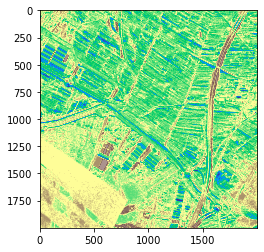

In [72]:
name = 'PNOA_2017_CLM-CAS_246-4450_ORT-CLA-IRC.tif'
aspect = 'aspect/aspect_'+name
slop = 'slop/slop_'+name
dem = 'dem/dem_'+name
raster_fns = [aspect,slop,dem]
band_list = []
for image in raster_fns:
    with rio.open(image, 'r') as src:
        band = src.read(1)
        band = np.nan_to_num(band)
        band_list.append(band)
bands_stack = np.dstack(band_list)
width, height, depth = bands_stack.shape
model_input = bands_stack.reshape(width * height, depth)
#model_input_scaled = scale(model_input)
#model_input_scaled = scaler.transform(model_input)
y_pred = kmeans.predict(model_input)
quantized_raster = np.reshape(y_pred, (width, height))
plt.imshow(quantized_raster, cmap="terrain")


###  Export and import  trained model 

Save the **Machine Learning model** based in KMeans through <i>joblib</i> and import it. By doing so we will be able to upload it to IBM_COS. 


In [48]:
tmp = '/home/jovyan/work/2nd experiment/' 

model = kmeans
name_model = 'kmeans.sav' 
joblib.dump(model, tmp +  name_model)

print("Trained model saved")

Trained model saved


In [49]:
loaded_model = joblib.load(tmp +  name_model)


print("Train model imported")

Train model imported


# Serverless Implementation - Lithops

We have reached the serverless implementation thanks to the framework **lithops**. The model which was trained before will be used to do clustring.



In [50]:
def map_classification(aspect,slop,dem):
    raster_fns = [aspect,slop,dem]
    band_list = []
    for image in raster_fns:
        with rio.open(image, 'r') as src:
            band = src.read(1)
            band = np.nan_to_num(band)
            band_list.append(band)
    bands_stack = np.dstack(band_list)
    width, height, depth = bands_stack.shape
    model_input = bands_stack.reshape(width * height, depth)




    loaded_model = joblib.load(tmp +  name_model)

    prediction = loaded_model.predict(model_input)  
    return  prediction




In [51]:
name = 'PNOA_2017_CLM-CAS_244-4452_ORT-CLA-IRC.tif'
aspect = 'aspect/aspect_'+name
slop = 'slop/slop_'+name
dem = 'dem/dem_'+name


Lithops v2.2.3 init for Localhost
ExecutorID df28dc/5 | JobID A000 - Selected Runtime: python3 
ExecutorID df28dc/5 | JobID A000 - Uploading function and data - Total: 1.3KiB
ExecutorID df28dc/5 | JobID A000 - map_classification() Invocation done - Total: 1 activations
ExecutorID df28dc/5 - Getting results...



ExecutorID df28dc/5 - Cleaning temporary data


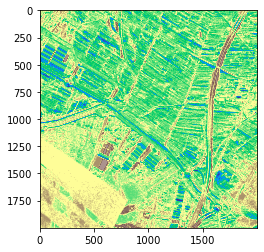

In [53]:
lt=lithops.FunctionExecutor(mode='localhost')
lt.call_async(map_classification,[aspect,slop,dem])
results = lt.get_result()
quantized_raster = np.reshape(results, (width, height))
plt.imshow(quantized_raster, cmap="terrain")


## Upload and prepare dataset in IBM Cloud

This code show us all Lidars that exist in the cloud ( ibm-cos-prueba bucket) and create list of lists. Each list contains 3 lidars names (DEM, Aspect and Slop).

In [189]:
# List Laz images that already stored in the cloud
lt=lithops.FunctionExecutor(config=config)

data= []
for file in lt.storage.list_keys('ibm-cos-prueba'):
                if "laz" in file:
                        # Define input and output files
                       
                        filez = file.split(".")[0]
                        input_dem = f"dem/dem_{filez}.tif"
                        input_slop = f"slop/slop_{filez}.tif"
                        input_aspect = f"aspect/aspect_{filez}.tif"
                        raster_fns = [input_dem,input_slop,input_aspect]   
                        data.append(raster_fns)
                

Lithops v2.2.3 init for IBM Cloud Functions - Namespace: ibm-cos_prueba - Region: us_east


Upload lidars (DEM, Aspect and Slop) to IBM cloud (ibm-cos-prueba bucket) using Lithops

In [8]:
for image in data:
    for lidar in range(len(image)):
        raster = rio.open(image[lidar]).read()
        bufImage  = io.BytesIO()
        joblib.dump(raster, bufImage)
        bufImage.seek(0)  # Without this line it fails
        lt.storage.put_object('ibm-cos-prueba', key= '%s'%(image[lidar]),data= bufImage)

   

Prepare training dataset that exist in IBM cloud, we get this data by using Lithops

In [190]:
# Define number of images we want to use it as training data.
num_of_img = 20
# Define X_train array to save training data in it. 
X_train = np.array([], dtype=np.int8).reshape(0,3) # pixels

# For loop read 20 images, after that saves the pixels in X_train
for i in range(num_of_img):

    band_list = []
    for image in data[i]:
        get_raster = lt.storage.get_object('ibm-cos-prueba', image)
        load_raster=joblib.load(io.BytesIO(get_raster))[0] 
        band = np.nan_to_num(load_raster)
        band_list.append(band)
    bands_stack = np.dstack(band_list)
    width, height, depth = bands_stack.shape
    model_input = bands_stack.reshape(width * height, depth)
    X_train = np.vstack((X_train,model_input))


In [191]:
len(X_train)

76468408

In [192]:
no_of_ranges =  np.arange(3, 11, 1)
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}
models = []
predicted = []
inertia_vals = []
s_scores = []
for n_clust in no_of_ranges:
    kmeans = KMeans(n_clusters=n_clust,**kmeans_kwargs)
    y_pred =kmeans.fit_predict(X_train)

    # Append model
    models.append(kmeans)

    # Calculate metrics
    s_scores.append(silhouette_score(X_train, y_pred, sample_size=1000))
    #inertia_vals.append(pipe.inertia_)
    inertia_vals.append(kmeans.inertia_)

Train the model

In [193]:
kmeans = KMeans(n_clusters=5,**kmeans_kwargs)
y_pred =kmeans.fit_predict(X_train)



Upload the trained model to IBM cloud bucket

In [194]:
model = kmeans
bufmodel  = io.BytesIO()
joblib.dump(model, bufmodel)
bufmodel.seek(0)  # Without this line it fails
lt.storage.put_object('ibm-cos-prueba', key= 'trained_model/kmeans.sav',data= bufmodel)

True

Names of data we want to predict

In [257]:
name = 'PNOA_2017_CLM-CAS_244-4452_ORT-CLA-RGB.tif'
aspect = 'aspect/aspect_'+name
slop = 'slop/slop_'+name
dem = 'dem/dem_'+name


Load kmeans model

In [258]:
get_model = lt.storage.get_object('ibm-cos-prueba', 'trained_model/kmeans.sav')
loaded_model = joblib.load(io.BytesIO(get_model)) 
loaded_model

KMeans(init='random', n_clusters=5, random_state=42)

Predict new data

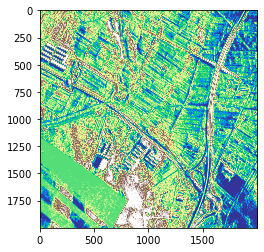

In [336]:
band_list = []
data = [aspect,slop,dem]
for image in data:
    get_raster = lt.storage.get_object('ibm-cos-prueba', image)
    load_raster=joblib.load(io.BytesIO(get_raster))[0] 
    band = np.nan_to_num(load_raster)
    band_list.append(band)
bands_stack = np.dstack(band_list)
width, height, depth = bands_stack.shape
model_input = bands_stack.reshape(width * height, depth)
prediction = loaded_model.predict(model_input)  
results = np.reshape(prediction, (width, height))
plt.imshow(results, cmap="terrain")